In [1]:
from paretoKnapsackInfluence import *

import shutil
import matplotlib as mpl
from pathlib import Path

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Dataset paths
base_dir = Path.cwd().resolve().parents[1]
nethept_path = base_dir / "datasets" / "raw_data" / "influence" / "NetHEPT" / "hep.txt"
netphy_path = base_dir / "datasets" / "raw_data" / "influence" / "NetPHY" / "phy.txt"

### Single-Run Plotting (Influence Maximization)

In [2]:
def findSingleRunSolutionsKnapsackInfluence(G, node_costs, maxBudget, num_samples=35, num_runs=6, dataset_name=""):
    '''
    Run algorithms for a fixed number of runs and plot each run in a subplot (no interpolation).
    Each run corresponds to an independent IM instance with its own Monte Carlo samples.
    '''
    # Cost grid (same for all budgets within this run)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack", "CoverageLinear", "TopK"]
    plot_algos = {
        "ParetoGreedy-Knapsack": True,
        "CoverageLinear": True,
        "PlainGreedy": True,
        "PlainGreedy-2Guess": True,
        "GreedyPlus-1Guess": False,
        "TopK": False
    }
    plot_algo_names = [alg for alg in algo_names if plot_algos.get(alg, False)]

    def sort_pairs(costs, infls):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, infls), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)

    def format_points(costs, infls):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, infls)]

    # Plot settings (match teams single task styling)
    colors = plt.get_cmap("tab10").colors
    marker_map = {
        "ParetoGreedy-Knapsack": "D",
        "CoverageLinear": "o",
        "PlainGreedy": "s",
        "PlainGreedy-2Guess": "^",
        "GreedyPlus-1Guess": "v",
        "TopK": "P"
    }
    marker_sizes = {"ParetoGreedy-Knapsack": 7, "CoverageLinear": 7, "PlainGreedy": 6, "PlainGreedy-2Guess": 6, "GreedyPlus-1Guess": 6, "TopK": 7}
    linestyle_map = {"ParetoGreedy-Knapsack": '-', "CoverageLinear": '-', "PlainGreedy": ':', "PlainGreedy-2Guess": '--', "GreedyPlus-1Guess": '-.', "TopK": ':'}
    zorder_map = {"ParetoGreedy-Knapsack": 6, "CoverageLinear": 5, "TopK": 4, "GreedyPlus-1Guess": 3, "PlainGreedy-2Guess": 2, "PlainGreedy": 1}
    alpha_map = {"ParetoGreedy-Knapsack": 0.85, "CoverageLinear": 0.95, "TopK": 0.9, "GreedyPlus-1Guess": 0.9, "PlainGreedy-2Guess": 0.9, "PlainGreedy": 0.9}
    mfc_map = {"ParetoGreedy-Knapsack": None, "CoverageLinear": "white", "TopK": "white", "GreedyPlus-1Guess": None, "PlainGreedy-2Guess": "white", "PlainGreedy": None}

    # Prepare figure with shared legend (2 rows x 3 columns)
    n_runs = int(num_runs)
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = np.array(axes).reshape(-1)
    legend_handles = None
    legend_labels = None

    # Per-dataset runtime summary
    runtime_totals = {alg: 0.0 for alg in algo_names}

    for ax_idx in range(n_runs):
        ax = axes[ax_idx]

        # Generate graph samples once to share across algorithms (per run)
        graph_samples = []
        for _ in range(num_samples):
            G_sample = nx.Graph()
            neighbors = defaultdict(set)
            connected_components = defaultdict()
            for u, v, data in G.edges(data=True):
                success = np.random.uniform(0, 1)
                if success < data.get('weight', 0.1):
                    G_sample.add_edge(u, v)
                    neighbors[u].add(v)
                    neighbors[v].add(u)
            for c in nx.connected_components(G_sample):
                for node in c:
                    connected_components[node] = c
            graph_samples.append((G_sample, neighbors, connected_components))

        # Prefix Pareto + Coverage Linear (computed once at full budget)
        pareto_full = paretoKnapsackInfluence(
            G=G,
            node_costs=node_costs,
            budget=maxBudget,
            num_samples=num_samples,
            graph_samples=graph_samples
        )
        pp1_costs, pp1_influences, pp1_map, pp1_time = pareto_full.prefixParetoGreedy_1Guess()
        cl_costs, cl_influences, cl_map, cl_time = pareto_full.coverage_linear()

        # Per-budget results
        influences = {alg: [] for alg in algo_names}
        runtimes = {alg: [] for alg in algo_names}

        for budgetVal in cost_arr:
            pareto = paretoKnapsackInfluence(
                G=G,
                node_costs=node_costs,
                budget=budgetVal,
                num_samples=num_samples,
                graph_samples=graph_samples
            )

            # Plain Greedy
            plain_nodes, plain_infl, plain_cost, plain_time = pareto.plainGreedy()
            influences['PlainGreedy'].append(plain_infl)
            runtimes['PlainGreedy'].append(plain_time)

            # Two Guess Plain Greedy
            _, tg_infl, tg_cost, tg_time = pareto.twoGuessPlainGreedy()
            influences['PlainGreedy-2Guess'].append(tg_infl)
            runtimes['PlainGreedy-2Guess'].append(tg_time)

            # One Guess Greedy Plus
            _, og_infl, og_cost, og_time = pareto.oneGuessGreedyPlus()
            influences['GreedyPlus-1Guess'].append(og_infl)
            runtimes['GreedyPlus-1Guess'].append(og_time)

            # Top-k (use #nodes chosen by PlainGreedy)
            k_val = max(1, len(plain_nodes))
            _, tk_infl, tk_cost, tk_time = pareto.top_k(k_val)
            influences['TopK'].append(tk_infl)
            runtimes['TopK'].append(tk_time)

        runtimes['ParetoGreedy-Knapsack'].append(pp1_time)
        runtimes['CoverageLinear'].append(cl_time)

        # Log pareto points per algorithm
        pg_costs, pg_infls = sort_pairs(pp1_costs, pp1_influences)
        cl_costs_sorted, cl_infls_sorted = sort_pairs(cl_costs, cl_influences)
        logging.info("Run %d pareto points - ParetoGreedy-Knapsack: %s", ax_idx, format_points(pg_costs, pg_infls))
        logging.info("Run %d pareto points - CoverageLinear: %s", ax_idx, format_points(cl_costs_sorted, cl_infls_sorted))
        logging.info("Run %d pareto points - PlainGreedy: %s", ax_idx, format_points(cost_arr, influences['PlainGreedy']))
        logging.info("Run %d pareto points - PlainGreedy-2Guess: %s", ax_idx, format_points(cost_arr, influences['PlainGreedy-2Guess']))
        logging.info("Run %d pareto points - GreedyPlus-1Guess: %s", ax_idx, format_points(cost_arr, influences['GreedyPlus-1Guess']))
        logging.info("Run %d pareto points - TopK: %s", ax_idx, format_points(cost_arr, influences['TopK']))

        series_map = {
            "ParetoGreedy-Knapsack": sort_pairs(pp1_costs, pp1_influences),
            "CoverageLinear": sort_pairs(cl_costs, cl_influences),
            "PlainGreedy": (cost_arr, np.array(influences['PlainGreedy'], dtype=float)),
            "PlainGreedy-2Guess": (cost_arr, np.array(influences['PlainGreedy-2Guess'], dtype=float)),
            "GreedyPlus-1Guess": (cost_arr, np.array(influences['GreedyPlus-1Guess'], dtype=float)),
            "TopK": (cost_arr, np.array(influences['TopK'], dtype=float))
        }

        for i, alg in enumerate(plot_algo_names):
            color = colors[i % len(colors)]
            marker = marker_map.get(alg, 'o')
            label = rf"\texttt{{{alg}}}"
            x_vals, y_vals = series_map[alg]
            ax.plot(
                x_vals, y_vals,
                label=(label if ax_idx == 0 else "_nolegend_"),
                color=color,
                linestyle=linestyle_map.get(alg, ':'),
                marker=marker,
                markersize=marker_sizes.get(alg, 6),
                markeredgewidth=1.2,
                markeredgecolor='k',
                markerfacecolor=(mfc_map.get(alg) if mfc_map.get(alg) is not None else color),
                linewidth=1.8,
                alpha=alpha_map.get(alg, 0.9),
                zorder=zorder_map.get(alg, 1)
            )

        ax.set_title("")
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', labelsize=24)

        if ax_idx == 0:
            legend_handles, legend_labels = ax.get_legend_handles_labels()

        # Runtime summary for this run
        for alg in algo_names:
            total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
            runtime_totals[alg] += total_runtime

    # Hide unused subplots if any
    for ax in axes[n_runs:]:
        ax.axis('off')

    if legend_handles is not None:
        fig.legend(legend_handles, legend_labels, loc='upper center', ncol=3, fontsize=20, frameon=False)

    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            if idx >= len(axes):
                continue
            ax = axes[idx]
            if r == n_rows - 1:
                ax.set_xlabel(r'Seed cost ($c_\ell$)', fontsize=24)
            if c == 0:
                ax.set_ylabel(r'Influence spread ($f$)', fontsize=24)

    fig.tight_layout(rect=[0.03, 0.03, 1, 0.9])

    # Save figure
    plots_dir = base_dir / "plots" / "knapsack" / "single"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_run.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        runtime_lines.append(f"  - {alg}: {runtime_totals[alg]:.3f}")
    logging.info("\n".join(runtime_lines))

## NetHEPT

2026-02-03 17:10:11,793 |INFO: Imported influence graph with 169 nodes and 793 edges
2026-02-03 17:10:11,892 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=15
2026-02-03 17:10:12,402 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=1.0
2026-02-03 17:10:12,413 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=2.0
2026-02-03 17:10:12,441 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=3.0
2026-02-03 17:10:12,521 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=4.0
2026-02-03 17:10:12,736 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=5.0
2026-02-03 17:10:13,219 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=6.0
2026-02-03 17:10:14,151 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=7.0
2026-02-03 17:10:15,

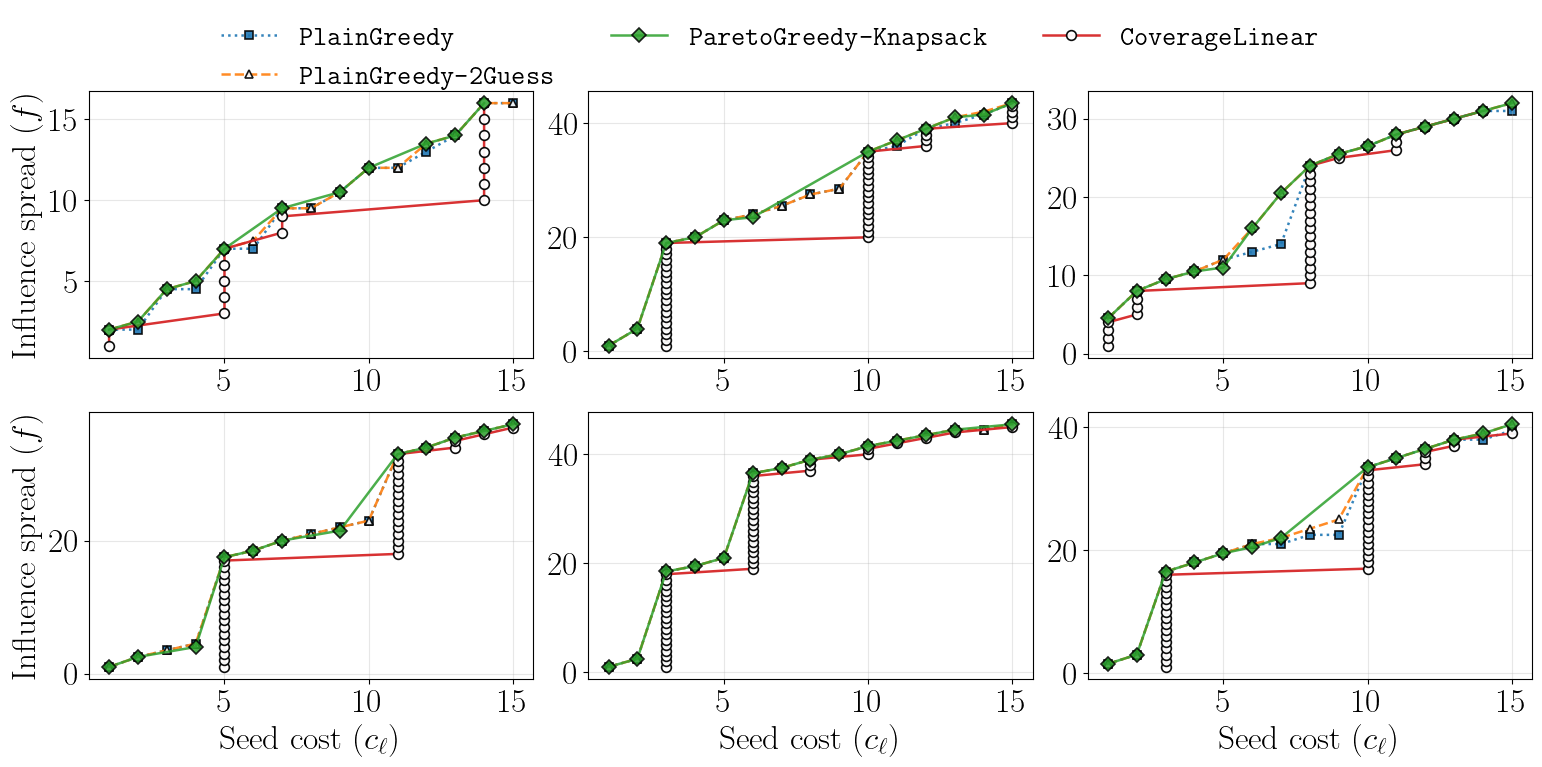

2026-02-03 17:13:54,529 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.343
  - PlainGreedy-2Guess: 182.871
  - GreedyPlus-1Guess: 34.197
  - ParetoGreedy-Knapsack: 0.632
  - CoverageLinear: 1.717
  - TopK: 0.140


In [3]:
# Load NetHEPT graph and node costs
G_HEPT, node_costs_HEPT = import_influence_data(nethept_path)

# Run for NetHEPT
findSingleRunSolutionsKnapsackInfluence(
    G_HEPT,
    node_costs_HEPT,
    maxBudget=15,
    num_samples=2,
    num_runs=6,
    dataset_name="NetHEPT"
 )

## NetPHY

2026-02-03 17:13:56,178 |INFO: Imported influence graph with 151 nodes and 735 edges
2026-02-03 17:13:56,223 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=15
2026-02-03 17:13:56,561 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=1.0
2026-02-03 17:13:56,571 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=2.0
2026-02-03 17:13:56,588 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=3.0
2026-02-03 17:13:56,627 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=4.0
2026-02-03 17:13:56,756 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=5.0
2026-02-03 17:13:57,041 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=6.0
2026-02-03 17:13:57,663 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=7.0
2026-02-03 17:13:58,

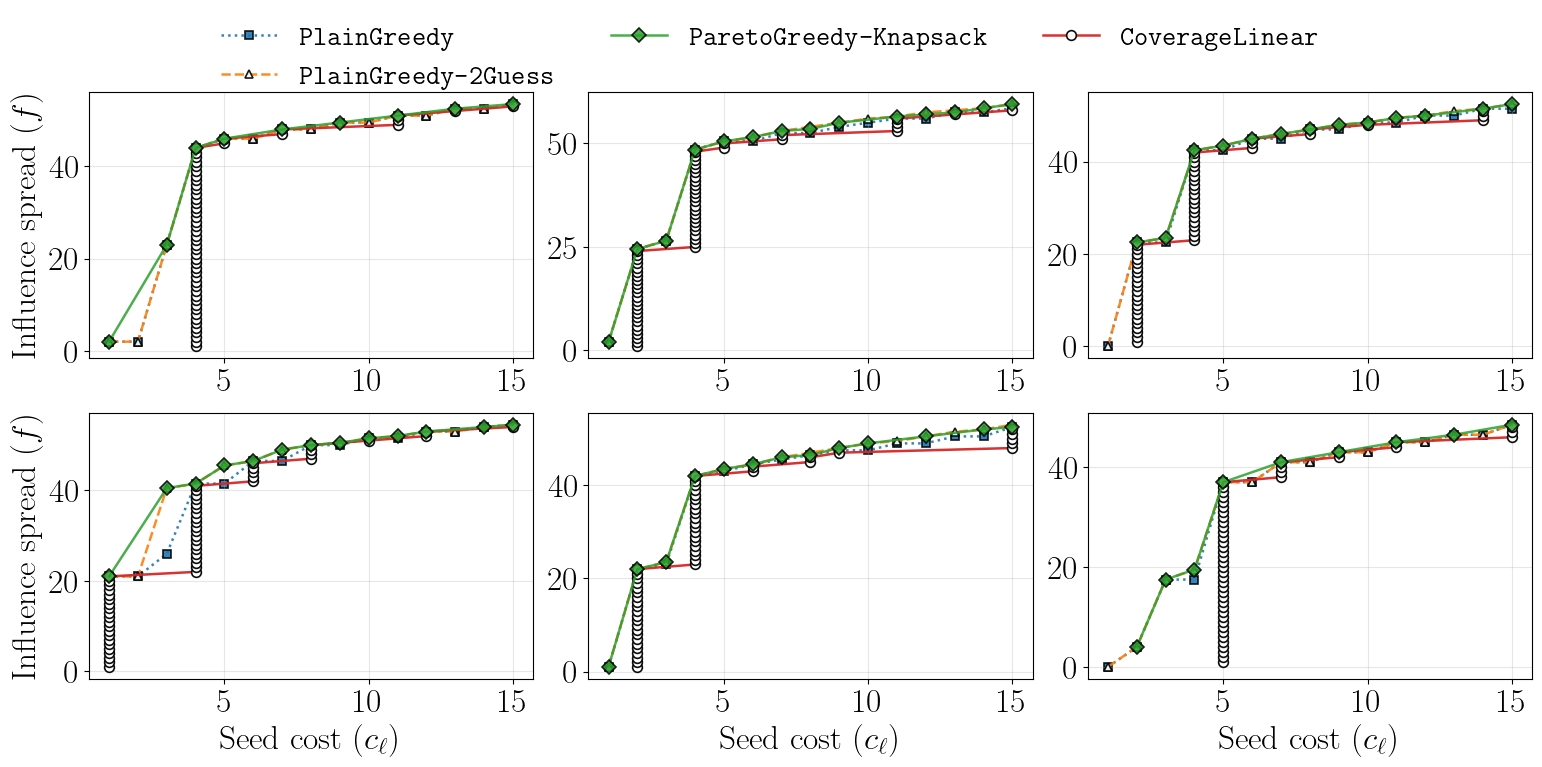

2026-02-03 17:18:26,727 |INFO: Runtime summary (seconds):
  - PlainGreedy: 0.383
  - PlainGreedy-2Guess: 232.221
  - GreedyPlus-1Guess: 34.249
  - ParetoGreedy-Knapsack: 1.087
  - CoverageLinear: 1.299
  - TopK: 0.123


In [4]:
# Load NetPHY graph and node costs
G_PHY, node_costs_PHY = import_influence_data(netphy_path)

# Run for NetPHY
findSingleRunSolutionsKnapsackInfluence(
    G_PHY,
    node_costs_PHY,
    maxBudget=15,
    num_samples=2,
    num_runs=6,
    dataset_name="NetPHY"
 )